# Notebook 1: Environment and Preprocessing

**Objective:** The goal of this notebook is to transform the standard `CartPole-v1` environment, which provides state information as a vector, into a custom environment that provides screen pixels as its state. This is the crucial first step in building an agent that learns from visual input.

We will perform three main tasks:
1.  **Initialize and inspect** the base Gymnasium environment.
2.  **Develop a preprocessing pipeline** using OpenCV to convert raw screen captures into a format suitable for a convolutional neural network.
3.  **Create a custom Gymnasium Wrapper** to handle this transformation seamlessly.

In [2]:
# ==============================================================================
# SETUP AND INSTALLATIONS
# ==============================================================================
from google.colab import drive
import os

# Mount Google Drive to access project files
drive.mount('/content/drive')

# Define the path to the project directory in Google Drive
# IMPORTANT: Make sure to update this path!
PROJECT_PATH = '/content/drive/My Drive/PortfolioProjects/visual_cartpole_rl'

# Create a symlink to the project path for easier access.
# Allowing to use '/project' as a shortcut.
if not os.path.exists('/project'):
    !ln -sfn '{PROJECT_PATH}' /project
else:
    print("Symlink '/project' already exists.")

# 1. Install system dependencies for Box2D
!apt-get update && apt-get install -y swig

# Install the necessary libraries
# - gymnasium[box2d]: The core environment library.
# - stable-baselines3[extra]: The RL training library.
# - opencv-python-headless: For image processing without needing a display.
!pip install gymnasium[box2d] stable-baselines3[extra] opencv-python-headless -q

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,690 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu

## Step 1: Library Imports 📚

Importing all the necessary libraries for this notebook.

In [4]:
# ==============================================================================
# LIBRARY IMPORTS
# ==============================================================================
import gymnasium as gym
from gymnasium.spaces import Box
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Step 2: Initialize the Base Environment 🎮

We will start by creating an instance of the standard `CartPole-v1` environment. The key here is setting `render_mode='rgb_array'`, which asks Gymnasium to generate an image of the environment's state as a NumPy array instead of trying to render it to a pop-up window. For visualization we capture one frame to see what the raw output looks like.

Initial screen shape: (400, 600, 3)



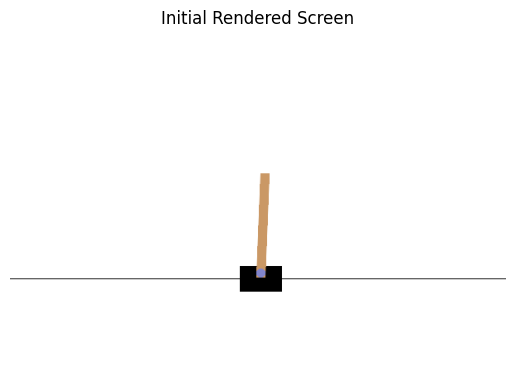

In [12]:
# ==============================================================================
# INITIALIZE AND INSPECT THE BASE ENVIRONMENT
# ==============================================================================
# Create the CartPole environment
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Reset the environment to get an initial state
env.reset()

# Render the environment and get the screen image as a NumPy array
initial_screen = env.render()

# Print the shape of the rendered screen
# The output will be in this format: (Height, Width, Channels), e.g., (400, 600, 3)
print(f"Initial screen shape: {initial_screen.shape}\n")

# Display the initial screen
plt.imshow(initial_screen)
plt.title("Initial Rendered Screen")
plt.axis('off')
plt.show();

env.close()

## Step 3: Develop the Image Preprocessing Pipeline 🖼️

The raw output from the environment (e.g., a 400x600*3 color image) is too large and contains unnecessary information. Feeding this directly to a convolutional neural network would be computationally expensive and will slow down training.

Our preprocessing pipeline will:
1.  **Crop the image** to focus only on the relevant area (the cart and the pole).
2.  **Convert the image to grayscale** to reduce the data from 3 color channels to 1.
3.  **Resize the image** to a smaller, standard size (e.g., 84x84), which is common in Deep RL literature.

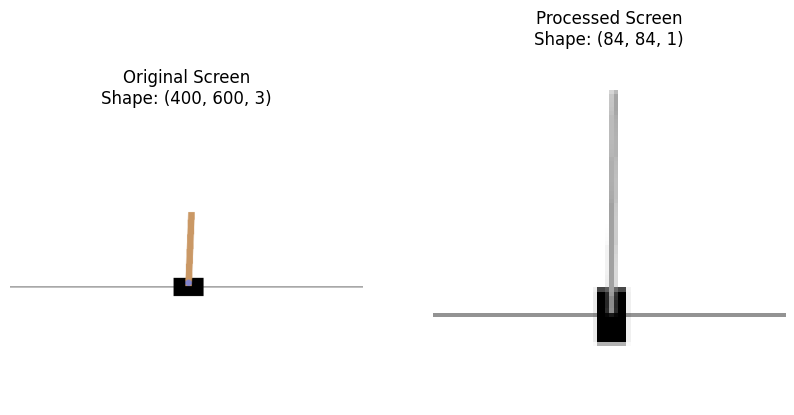

In [13]:
# ==============================================================================
# IMAGE PREPROCESSING FUNCTION AND VISUALIZATION
# ==============================================================================
def preprocess_frame(frame):
    """
    Preprocesses a single frame from the CartPole environment.

    Args:
        frame (np.array): The raw RGB frame from env.render().

    Returns:
        np.array: The processed grayscale frame.
    """
    # 1. Crop the screen to focus on the cart and pole.
    # The exact values [150:350, :] might need tweaking based on the render,
    # but these are generally good for CartPole-v1.
    processed_frame = frame[150:350, :]

    # 2. Convert the image to grayscale.
    processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2GRAY)

    # 3. Resize the image to 84x84 pixels.
    processed_frame = cv2.resize(
        processed_frame, (84, 84), interpolation=cv2.INTER_AREA
    )

    # 4. Add a channel dimension for the CNN.
    # The CNN expects an input shape of (Height, Width, Channels).
    # Since we have a grayscale image, we add a 1-channel dimension.
    return processed_frame[:, :, None]

# --- Visualization ---
# Visualizing the effect of preprocessing
processed_screen = preprocess_frame(initial_screen)

# Create a figure to compare the original and processed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(initial_screen)
axes[0].set_title(f"Original Screen\nShape: {initial_screen.shape}")
axes[0].axis('off')

# Processed Image
# We use cmap='gray' to display the grayscale image correctly.
# .squeeze() removes the channel dimension for visualization.
axes[1].imshow(processed_screen.squeeze(), cmap='gray')
axes[1].set_title(f"Processed Screen\nShape: {processed_screen.shape}")
axes[1].axis('off')

plt.show()

## Step 4: Create a Custom Gymnasium Wrapper 📦

Now we will create a custom wrapper class. A wrapper is the standard approach to modify the behavior of a Gymnasium environment without altering its source code.

The `ImageWrapper` will inherit from `gym.ObservationWrapper` and do two key things:
1.  **Modify the `observation_space`**: The environment's observation space will no longer be a vector of 4 numbers, but an 84x84x1 image. We must explicitly define this new shape.
2.  **Override the `observation` method**: This method takes the original observation (the state vector) and returns our new, processed image observation instead. It will be called automatically by `env.step()` and `env.reset()`.

In [14]:
# ==============================================================================
# GYMNASIUM WRAPPER CLASS
# ==============================================================================
class ImageWrapper(gym.ObservationWrapper):
    """
    A custom Gymnasium wrapper to preprocess image observations and modify the
    observation space.
    """
    def __init__(self, env):
        super().__init__(env)
        # Define the new observation space.
        # It's an 84x84 image with 1 channel (grayscale).
        # The values range from 0 to 255 (uint8).
        self.observation_space = Box(
            low=0, high=255, shape=(84, 84, 1), dtype=np.uint8
        )

    def observation(self, obs):
        """
        Processes the observation before it is returned by the environment.
        """
        # The original `obs` is the state vector, which will be ignored.
        # We render the environment to get the pixels.
        frame = self.env.render()
        # Apply the cv2 preprocessing function.
        return preprocess_frame(frame)

## Step 5: Test the Wrapped Environment 🧪

The final step is to test our new wrapper. We will instantiate our `ImageWrapper` and call its `reset()` method. We'll then check the shape of the observation it returns. If it matches the `observation_space` we defined (84, 84, 1), our wrapper is working correctly!

Observation shape: (84, 84, 1)
Observation data type: uint8
Min pixel value: 0
Max pixel value: 255



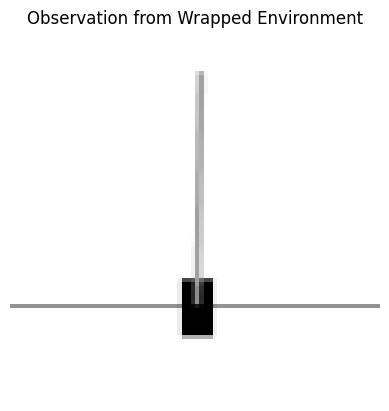

In [16]:
# ==============================================================================
# TESTING THE OBSERVATION WRAPPER
# ==============================================================================
# Create the base environment
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Wrap the environment with our custom ImageWrapper
wrapped_env = ImageWrapper(env)

# Reset the wrapped environment to get the first observation
obs, info = wrapped_env.reset()

# Check the properties of the observation
print(f"Observation shape: {obs.shape}")
print(f"Observation data type: {obs.dtype}")
print(f"Min pixel value: {obs.min()}")
print(f"Max pixel value: {obs.max()}\n")

# Display the observation received from the wrapped environment
plt.imshow(obs.squeeze(), cmap='gray')
plt.title("Observation from Wrapped Environment")
plt.axis('off')
plt.show()

# Clean up
wrapped_env.close()

## Notebook Conclusion ✅

We have successfully created and verified the custom Gymnasium environment. The `ImageWrapper` correctly intercepts the environment's rendering, processes it into an 84x84x1 grayscale image, and provides it as the new state observation.

We are now ready for the next phase: **building a custom CNN policy and training an agent** to learn from these visual inputs. This is articulated in the next notebook, `2_Training_the_Agent.ipynb`!